# What structural characteristics impact the house price in Shanghai, China and how can houses be clustered according to these characteristics？
Student Number：20146932

## PART1：DATA PREPARATION
First import the basic libraries we need.

In [1]:
import os
from requests import get
from urllib.parse import urlparse

import pandas as pd
import numpy as np

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
plt.style.use("bmh")
plt.rc('font',family='SimHei', size=13)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn import model_selection
import statsmodels.api as sm
from scipy.stats import f
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

Create a directory for the figures we are going to make, download the .csv data we downloaded from Lianjia, and take a glance at the shape, colomns and missing values of the data.

In [2]:
workspace = os.getcwd()
if not os.path.exists(workspace + '/figs'):
    os.mkdir(workspace + '/figs')

data_url = 'https://raw.githubusercontent.com/lizhiyuan913/QuantitativeMethod/main/SHlianjia.csv'
data_path = './SHlianjia.csv'
url = urlparse(data_url)
filename  = os.path.split(url.path)[-1]

if not os.path.isfile(data_path):   
    print(f"{data_path} not found, downloading!")
    with open(data_path, "wb") as file:
        response = get(data_url)
        file.write(response.content) 
    print('Done downloading...')
else:
    print(f"Found {data_path} locally!")

# improt the Lianjia second-hand housing dataset.
data_df = pd.read_csv('SHlianjia.csv')
# take a glance at the shape, colomns and missing values of the data.
data_df.shape
data_df.info()
# check missing values.
data_df.isnull().sum().sort_values(ascending=False)

Found ./SHlianjia.csv locally!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26768 entries, 0 to 26767
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Direction   26768 non-null  object 
 1   District    26768 non-null  object 
 2   Floor       26768 non-null  int64  
 3   Garden      26768 non-null  object 
 4   Id          26768 non-null  int64  
 5   Layout      26768 non-null  object 
 6   Price       26768 non-null  float64
 7   Region      26768 non-null  object 
 8   Renovation  26768 non-null  object 
 9   Size        26768 non-null  float64
 10  Subway      26768 non-null  object 
 11  Taxfree     26768 non-null  object 
 12  Year        26768 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 2.7+ MB


Year          0
Taxfree       0
Subway        0
Size          0
Renovation    0
Region        0
Price         0
Layout        0
Id            0
Garden        0
Floor         0
District      0
Direction     0
dtype: int64

Make a copy of the data, and add the Unit Price colomn, and rearrange the colomns.

In [3]:
# make a copy of the data.
df = data_df.copy()
# add the Unit Price colomn for the dataset.
df['PerPrice'] = data_df['Price']/data_df['Size']
# rearrange the colomns.
columns = ['Region','Layout','Floor','Year','Renovation','Subway','Taxfree','Size','PerPrice','Price']
df = pd.DataFrame(df,columns = columns)
# have a look at the rearranged dataset.
df.describe(include='O')
df.describe()

,Floor,Year,Size,PerPrice,Price
count,26768.000000,26768.000000,26768.000000,26768.000000,26768.000000
mean,10.753624,1999.051255,90.668858,5.621241,518.691520
std,7.568613,11.651064,235.588424,2.726526,603.517675
min,1.000000,1911.000000,6.000000,0.018995,40.000000
25%,6.000000,1994.000000,53.000000,3.764541,240.000000
50%,6.000000,1999.000000,76.000000,5.333333,355.000000
75%,15.000000,2008.000000,106.000000,6.800000,570.000000
max,60.000000,2020.000000,36851.000000,41.036717,19000.000000


Convert the Subway and Taxfree into dummy variables.

In [4]:
df['Subway'] = df['Subway'].apply(lambda x : 1 if (x == '是') else 0)
df['Taxfree'] = df['Taxfree'].apply(lambda x : 1 if (x == '是') else 0)

Replace the Mandarin Chinese in the Regions and Renovation columns with characters.

In [5]:
# Region
regions = {'浦东': 'Pudong', '闵行': 'Minhang', '宝山': 'Baoshan', '徐汇': 'Xuhui', '杨浦': 'Yangpu', '长宁': 'Changning', 
           '松江': 'Songjiang', '静安':'Jingan', '虹口': 'Hongkou', '青浦': 'Qingpu', '金山': 'Jinshan', '奉贤': 'Fengxian', 
           '黄浦': 'Huangpu', '嘉定': 'Jiading', '普陀': 'Putuo'}
regions_abbr = {'浦东': 'PD', '闵行': 'MH', '宝山': 'BS', '徐汇': 'XH', '杨浦': 'YP', '长宁': 'CN', '松江': 'SJ', '静安':'JA', 
                '虹口': 'HK', '青浦': 'QP', '金山': 'JS', '奉贤': 'FX', '黄浦': 'HP', '嘉定': 'JD', '普陀': 'PT'}
df['Region_abbr'] = df['Region'].apply(lambda x : regions_abbr[x])
df['Region'] = df['Region'].apply(lambda x : regions[x])

# Renovation
renovations = {'精装': 'Fine', '简装': 'Simple', '毛坯': 'Blank', '其他': 'Other'}
df['Renovation'] = df['Renovation'].apply(lambda x : renovations[x])

Layout preprocessing：replace 'Layout' with the total number of bedrooms, living rooms and dining room as'RoomNum'.

In [6]:
# Layout preprocessing
df['RoomNum'] = df['Layout'].str.extract('(^\d).*', expand=False).astype('int64') + df['Layout'].str.extract('^\d.*?(\d).*', expand=False).astype('int64')
df = df.drop(['Layout'],axis=1)

Check and delete outliners with boxplots in unit price, total price and area and delete rows with floor >40.

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


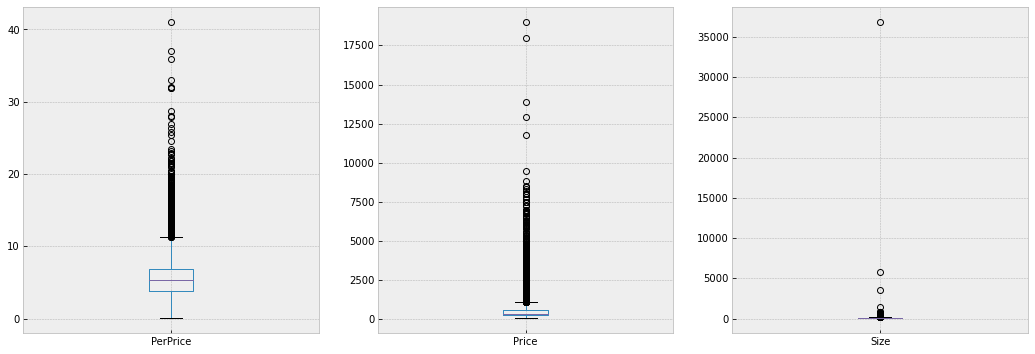

In [7]:
#check outliners with boxplots in unit price, total price and area.
fig,ax = plt.subplots(1,3,figsize = (18,6))
df['PerPrice'].plot.box(ax = ax[0])
df['Price'].plot.box(ax = ax[1])
df['Size'].plot.box(ax = ax[2])
plt.savefig('./figs/fig1.jpg')
plt.show()

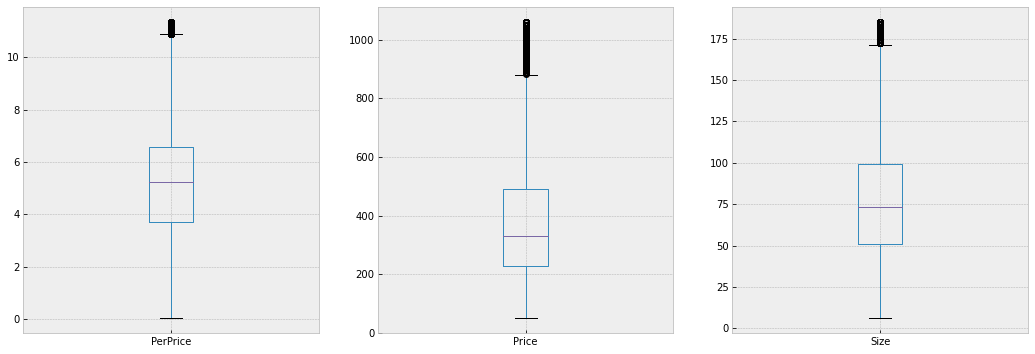

25753
24484
25377


In [8]:
# delete rows with floor >40.
df = df[df['Floor']<=40]
# delete outliers.
df['id'] = [i for i in range(1,len(df)+1)]
def get_norm(data, col):
    q1 = data[col].quantile(q = 0.25)
    q3 = data[col].quantile(q = 0.75)
    iqr = q3 - q1
    t1 = q1 - 1.5*iqr
    t2 = q3 + 1.5*iqr
    return data[(data[col]>t1) & (data[col]<t2)][['id',col]]
    
pprice_norm = get_norm(df,'PerPrice')
price_norm = get_norm(df,'Price')
size_norm = get_norm(df,'Size')
# recheck after deleting outliers.
fig,ax = plt.subplots(1,3,figsize = (18,6))
pprice_norm['PerPrice'].plot.box(ax = ax[0])
price_norm['Price'].plot.box(ax = ax[1])
size_norm['Size'].plot.box(ax = ax[2])
plt.savefig('./figs/fig2.jpg')
plt.show()
print(len(pprice_norm))
print(len(price_norm))
print(len(size_norm))

In [9]:
#take a glace at the data and double check for outliers.
del df['PerPrice']
del df['Price']
del df['Size']
df_norm = pd.merge(pprice_norm, price_norm, left_on='id', right_on='id', how='right')
df_norm = pd.merge(size_norm, df_norm,left_on='id', right_on='id', how='right')
df = pd.merge(df, df_norm, left_on='id', right_on='id', how='right')
del df['id']
df.isnull().sum()

Region           0
Floor            0
Year             0
Renovation       0
Subway           0
Taxfree          0
Region_abbr      0
RoomNum          0
Size           400
PerPrice       357
Price            0
dtype: int64

Create the Age column and remove rows with missing values.

In [10]:
# create the Age column.
df['Age']=2021-df['Year']

# remove rows with missing values.
print(len(df))
df = df.dropna()
df.isnull().sum()
print(len(df))

24484
23727


## PART2: FIRST MULTIPLE LINEAR REGRESSION
### (before normaliztion and logtransformation)

In [11]:
# set font size and basecolor.
font_size = 30
color_base = "Blues_d"
sns.set(font_scale = 2)

Draw the distribution plots of independent variables.

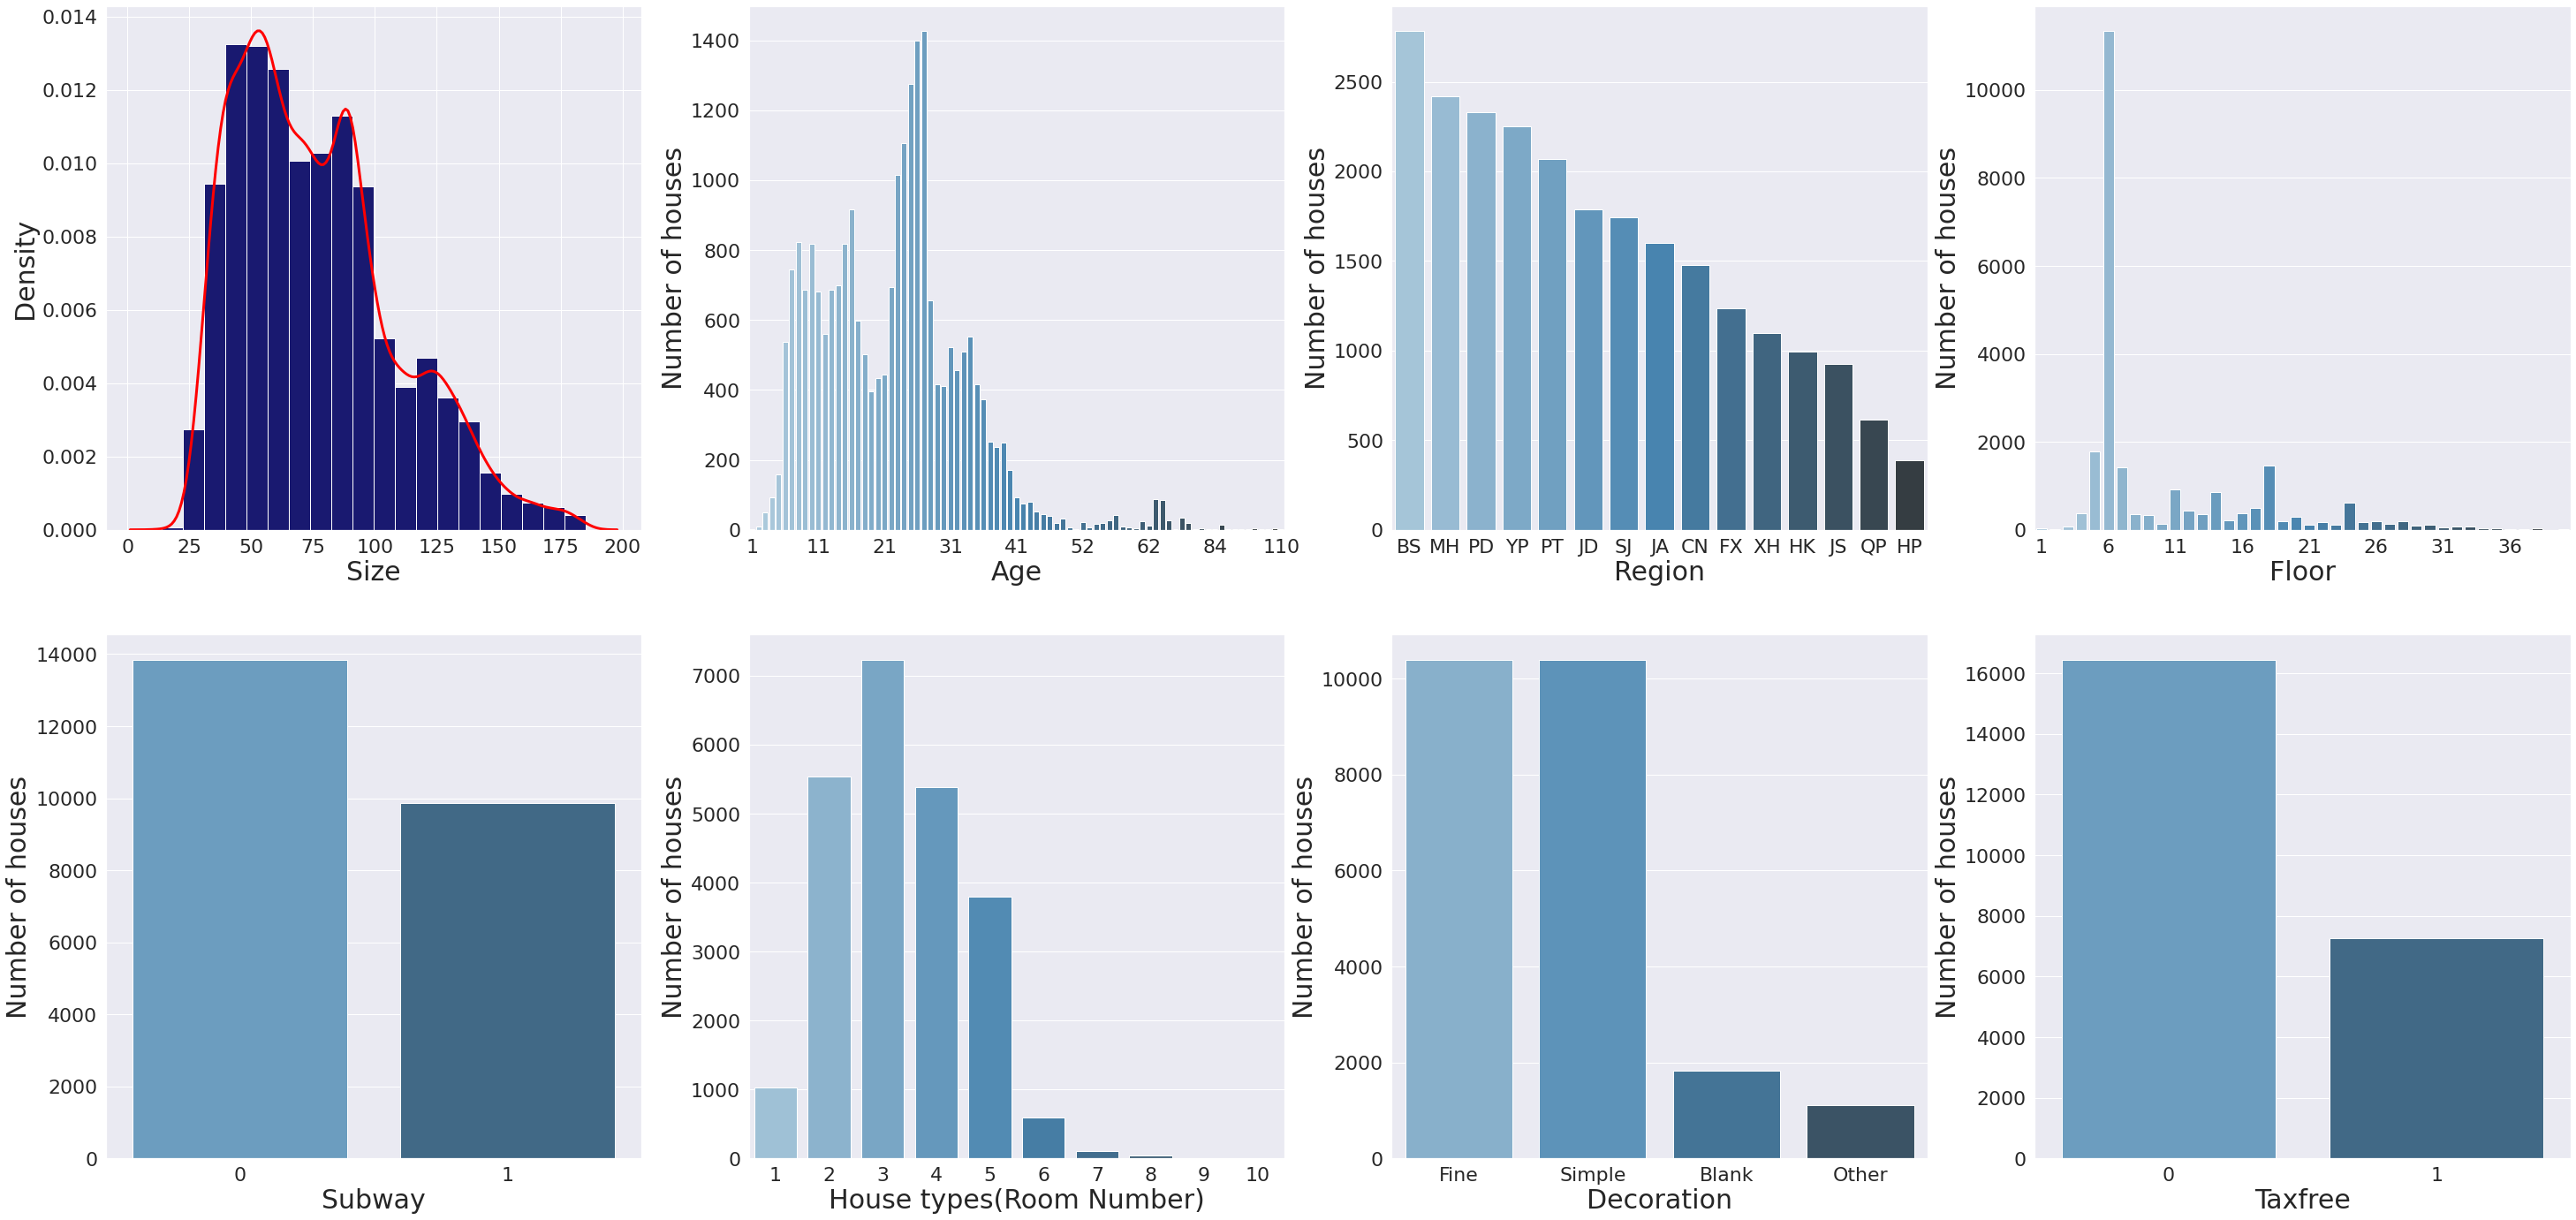

In [12]:
# Fig. 1 distribution plots of independent variables
f1, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(50, 24))
# size
sns.distplot(df['Size'], bins=20, kde=True, ax=ax1, hist_kws={'alpha': 1, 'color': 'midnightblue', 'edgecolor': 'white'},
             kde_kws={'color': 'red', 'linewidth': 3},)
ax1.set_xlabel('Size', fontsize=font_size)
ax1.set_ylabel('Density', fontsize=font_size)
# age
df_age_count = df.groupby('Age')['Price'].count().to_frame().reset_index()
age_xticks = list(range(0, df_age_count.shape[0], 10))
age_xlabels = [df_age_count['Age'][x] for x in age_xticks]
sns.barplot(x='Age', y='Price', palette=color_base, data=df_age_count, ax=ax2)
ax2.set_xticks(age_xticks)
ax2.set_xticklabels(age_xlabels)
ax2.set_xlabel('Age', fontsize=font_size)
ax2.set_ylabel('Number of houses', fontsize=font_size)
# region
df_house_count = df.groupby('Region_abbr')['Price'].count().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Region_abbr', y='Price', palette=color_base, data=df_house_count, ax=ax3)
ax3.set_xlabel('Region', fontsize=font_size)
ax3.set_ylabel('Number of houses', fontsize=font_size)
# floor
# sns.countplot(x='Floor', palette=color_base, data=df, ax=ax4)
df_floor_count = df.groupby('Floor')['Price'].count().to_frame().reset_index()
floor_xticks = list(range(0, df_floor_count.shape[0], 5))
floor_xlabels = [df_floor_count['Floor'][x] for x in floor_xticks]
sns.barplot(x='Floor', y='Price', palette=color_base, data=df_floor_count, ax=ax4)
ax4.set_xticks(floor_xticks)
ax4.set_xticklabels(floor_xlabels)
ax4.set_xlabel('Floor', fontsize=font_size)
ax4.set_ylabel('Number of houses', fontsize=font_size)
# subway
sns.countplot(df['Subway'], palette=color_base, ax=ax5)
ax5.set_xlabel('Subway', fontsize=font_size)
ax5.set_ylabel('Number of houses', fontsize=font_size)
# room
df = df[df['RoomNum'] != 0]
sns.countplot('RoomNum', palette=color_base, data=df, ax=ax6)
ax6.set_xlabel('House types(Room Number)', fontsize=font_size)
ax6.set_ylabel('Number of houses', fontsize=font_size)
# renovation
sns.countplot(df['Renovation'], palette=color_base, ax=ax7)
ax7.set_xlabel('Decoration', fontsize=font_size)
ax7.set_ylabel('Number of houses', fontsize=font_size)
# taxfree
sns.countplot(df['Taxfree'], palette=color_base, ax=ax8)
ax8.set_xlabel('Taxfree', fontsize=font_size)
ax8.set_ylabel('Number of houses', fontsize=font_size)

plt.savefig('./figs/fig3.jpg')
plt.show()

Draw bivariate plots between dependent and independent variables.

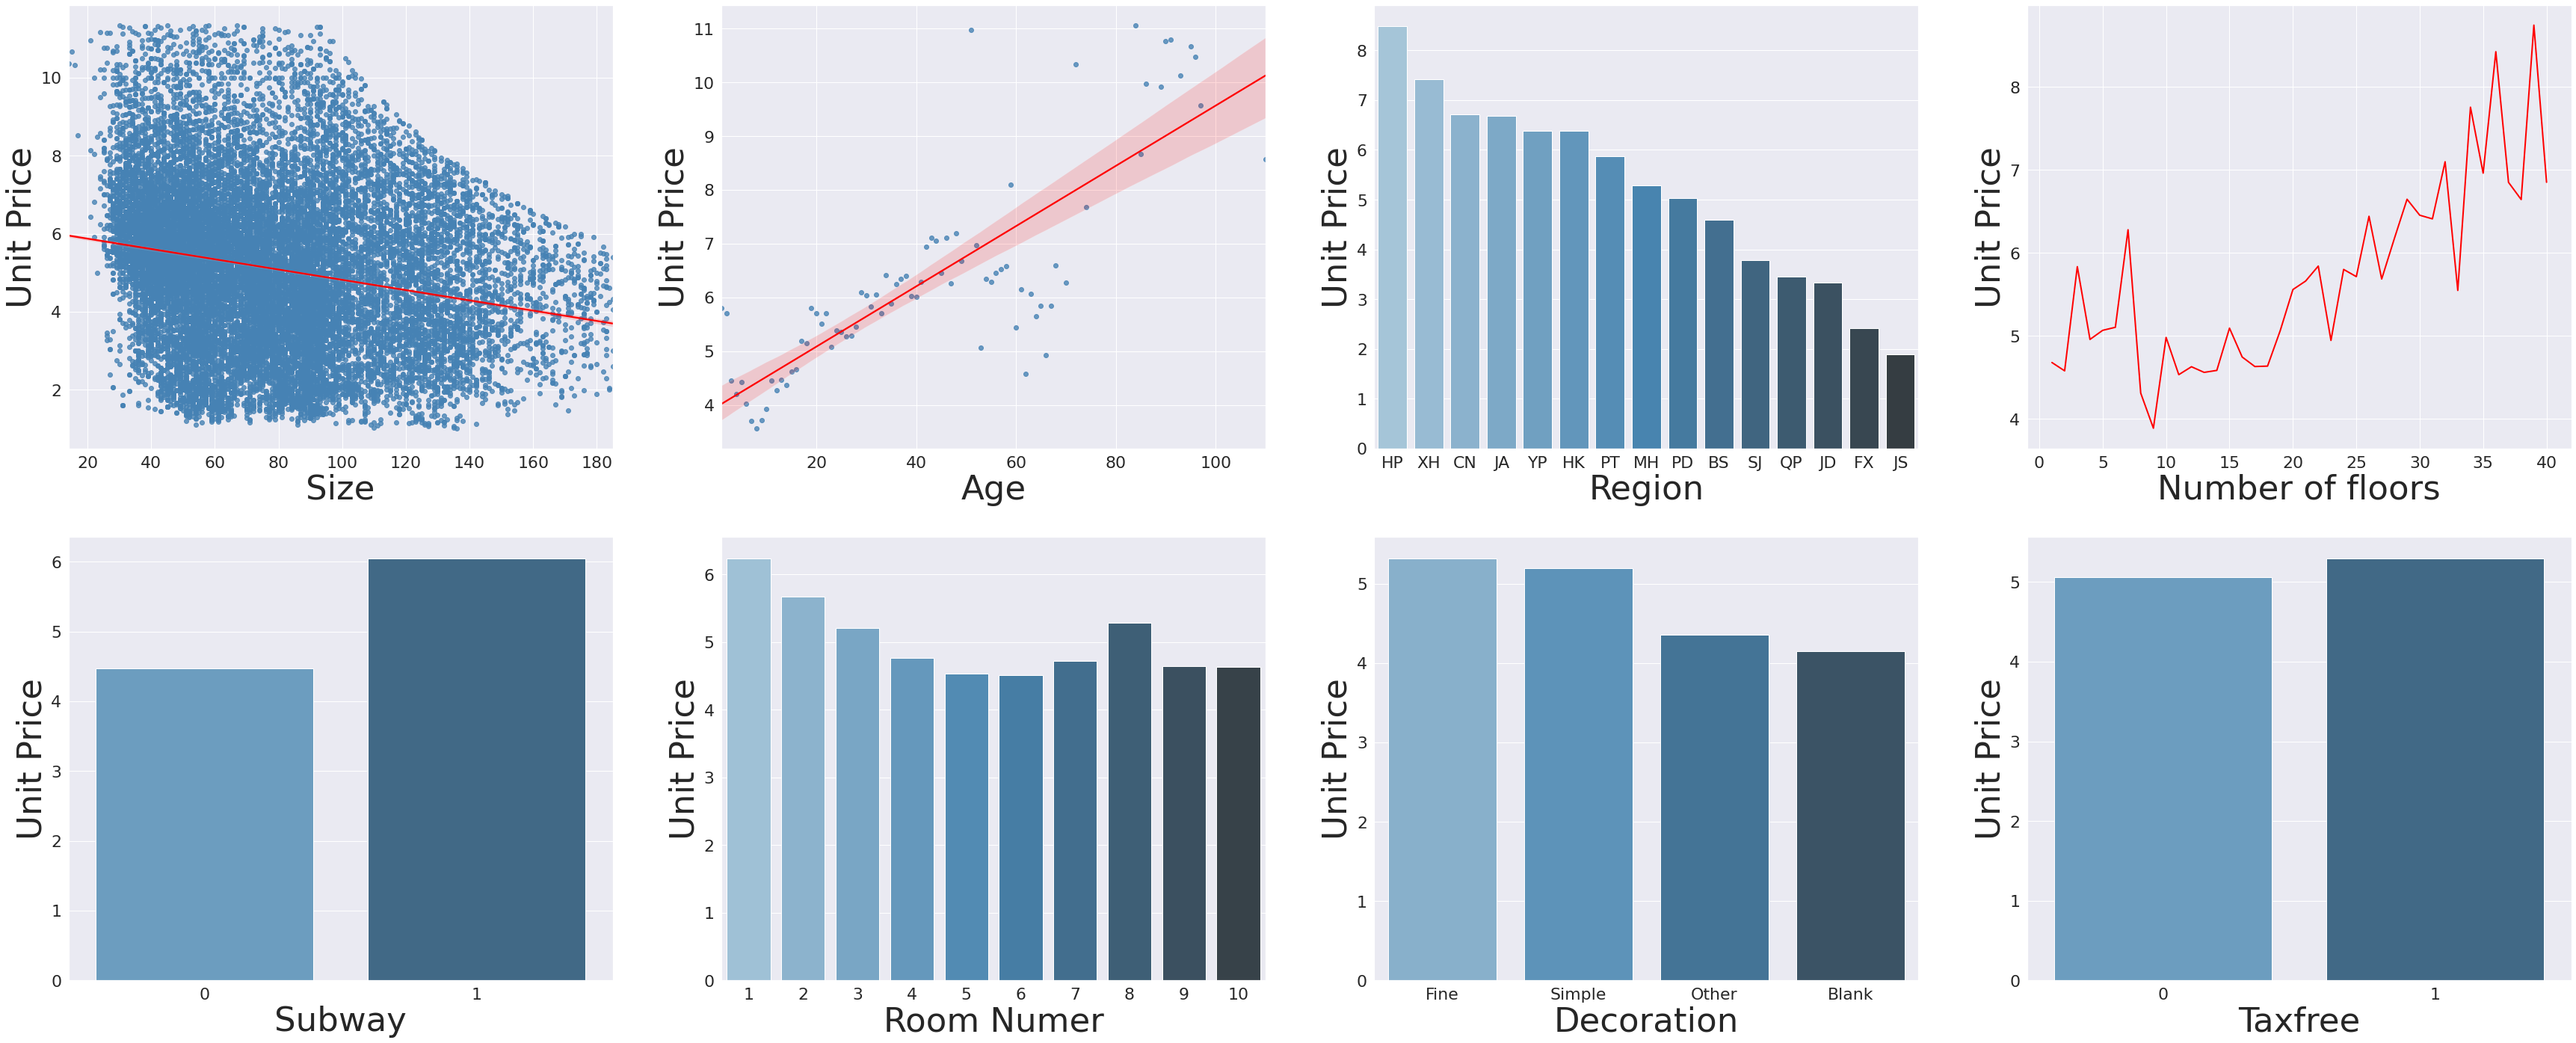

In [13]:
# Fig 2. bivariate plots between dependent and independent variables
f2, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(60,24))
# size
sns.regplot(x='Size', y='PerPrice', data=df, ax=ax1, scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax1.set_xlabel('Size', fontsize=font_size*1.5)
ax1.set_ylabel('Unit Price', fontsize=font_size*1.5)
# year
df_YeMean_Price = df.groupby('Age')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.regplot(x='Age', y='PerPrice',data=df_YeMean_Price, ax=ax2, scatter_kws={"color": "steelblue"}, line_kws={"color": "red"})
ax2.set_xlabel('Age', fontsize=font_size*1.5)
ax2.set_ylabel('Unit Price', fontsize=font_size*1.5)
# region
df_house_mean = df.groupby('Region_abbr')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Region_abbr', y='PerPrice', palette=color_base, data=df_house_mean, ax=ax3)
ax3.set_xlabel('Region', fontsize=font_size*1.5)
ax3.set_ylabel('Unit Price', fontsize=font_size*1.5)
# floor
df.groupby(df['Floor'])['PerPrice'].mean().plot(color='red',linewidth=2.0,linestyle='-',ax=ax4)
ax4.set_xlabel('Number of floors', fontsize=font_size*1.5)
ax4.set_ylabel('Unit Price', fontsize=font_size*1.5)
# subway
df_SuMean_Price = df.groupby('Subway')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Subway', y='PerPrice', palette=color_base, data=df_SuMean_Price, ax=ax5)
ax5.set_xlabel('Subway', fontsize=font_size*1.5)
ax5.set_ylabel('Unit Price', fontsize=font_size*1.5)
# room
df_RoomMean_Price = df.groupby('RoomNum')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='RoomNum', y='PerPrice', palette=color_base, data=df_RoomMean_Price, ax=ax6)
ax6.set_xlabel('Room Numer', fontsize=font_size*1.5)
ax6.set_ylabel('Unit Price', fontsize=font_size*1.5)
# renovation
df_ReMean_Price = df.groupby('Renovation')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Renovation', y='PerPrice', palette=color_base, data=df_ReMean_Price, ax=ax7)
ax7.set_xlabel('Decoration', fontsize=font_size*1.5)
ax7.set_ylabel('Unit Price', fontsize=font_size*1.5)
# taxfree
df_TaMean_Price = df.groupby('Taxfree')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
sns.barplot(x='Taxfree', y='PerPrice', palette=color_base, data=df_TaMean_Price, ax=ax8)
ax8.set_xlabel('Taxfree', fontsize=font_size*1.5)
ax8.set_ylabel('Unit Price', fontsize=font_size*1.5)

plt.savefig('./figs/fig4.jpg')
plt.show()

drop region as it wouldn't be needed hereinafter in the regressio, encode renovation ('Fine': 4, 'Simple': 3, 'Other': 2, 'Blank': 1) and draw the heatmap for independent variables.

In [14]:
# drop region as it wouldn't be needed hereinafter in the regression.
df = df.drop(['Region_abbr'],axis=1)

# Renovation encoding
renovation_encode = {'Fine': 4, 'Simple': 3, 'Other': 2, 'Blank': 1}
df['Decoration'] = df['Renovation'].apply(lambda x : renovation_encode[x])
del df['Renovation']

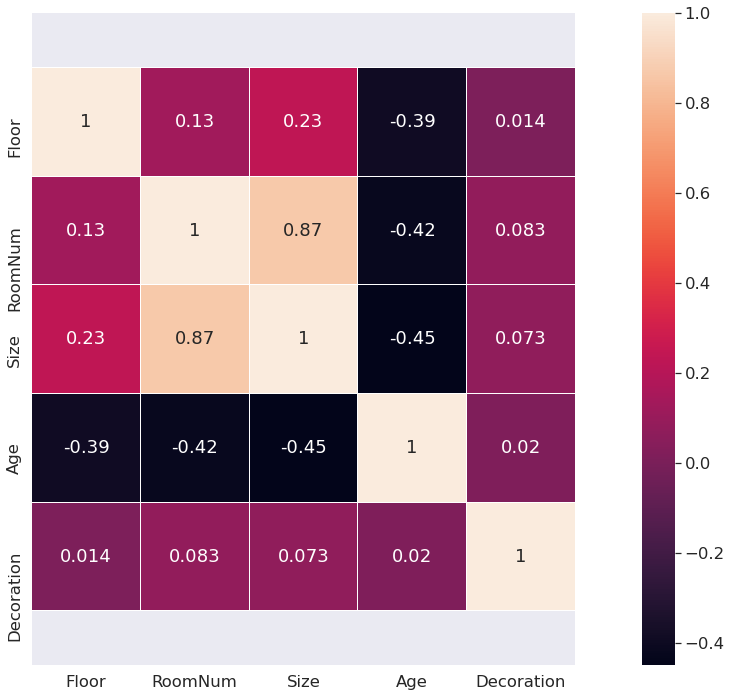

In [15]:
# Feature heatmap
df_h = df.drop(['PerPrice','Price','Subway','Taxfree','Year'], axis=1)
sns.set(font_scale=1.5)
colormap = plt.cm.RdBu
corr = df_h.corr()
plt.figure(figsize = (24,12))
ax = sns.heatmap(corr, square=True, linewidths=0.01, annot=True, fmt='.2g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
sns.set(font_scale = 1)
plt.savefig('./figs/fig5.jpg')
plt.show()

In [16]:
df.describe()

,Floor,Year,Subway,Taxfree,RoomNum,Size,PerPrice,Price,Age,Decoration
count,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000,23726.000000
mean,10.145958,1998.672722,0.416168,0.306415,3.330776,76.358341,5.129891,378.116446,22.327278,3.237461
std,6.803667,11.223436,0.492932,0.461014,1.232234,32.121809,1.991261,204.617972,11.223436,0.857721
min,1.000000,1911.000000,0.000000,0.000000,1.000000,14.000000,1.014706,50.000000,1.000000,1.000000
25%,6.000000,1993.000000,0.000000,0.000000,2.000000,51.000000,3.630952,228.250000,14.000000,3.000000
50%,6.000000,1998.000000,0.000000,0.000000,3.000000,71.000000,5.138330,325.000000,23.000000,3.000000
75%,14.000000,2007.000000,1.000000,1.000000,4.000000,94.000000,6.363636,470.000000,28.000000,4.000000
max,40.000000,2020.000000,1.000000,1.000000,10.000000,185.000000,11.344828,1060.000000,110.000000,4.000000


Columns with same values are dropped.

In [17]:
# drop columns with same values
original_cols=df.columns
drop_cols = []
for col in original_cols:
    col_unique_num = df[col].dropna().nunique()
    if col_unique_num == 1:
        drop_cols.append(col)
drop_cols
df.drop(columns=drop_cols, inplace=True)

Here, we adopt OLS to train and fit our prediction model for house prices.
After data processing, I devide training set and the test set with an 8:2 ratio and select features for learning and prices for predicting.

In [18]:
#normalization
def data_Znorm(df,*cols):
    df_n = df.copy()
    for col in cols:
        ma = df_n[col].max()
        mi = df_n[col].min()
        df_n[col + '_n'] = (df_n[col] - mi) / (ma - mi)
    return(df_n)

df_1 = data_Znorm(df,'Size','Age','Decoration','RoomNum','Floor')

df_1.columns

# split train set and test set
train,test,=train_test_split(df_1, test_size=0.2, random_state=0)

# select features for learning and prices for predicting
y_test = test['Price']
x_test = test.drop(['Price','PerPrice'],axis=1)

model_1 = sm.formula.ols(formula='Price ~ Size + Age+Decoration+RoomNum+Floor', data=train).fit() 

Although the model has been built, the quality of the model still needs the significance test of the model and the significance test of the regression coefficient.

In [19]:
ybar = df.Price.mean()

p=model_1.df_model
n= train.shape[0]

RSS = np.sum((model_1.fittedvalues-ybar)**2)

ESS = np.sum(model_1.resid**2)

F=(RSS/p)/(ESS/(n-p-1))
print('The real value of the F statistic：',F)


F_Theory= f.ppf(q=0.95,dfn=p,dfd=n-p-1)
print('The theoretical value of the F statistic：',F_Theory)

The real value of the F statistic： 3882.15526751791
The theoretical value of the F statistic： 2.2145704681120444


The calculated statistical F value is far greater than the theoretical F value, so the null hypothesis can be rejected here, that is, the multiple linear regression is considered to be significant, that is, the partial regression coefficients of the regression model are not all 0.

In [20]:
#return the results of the first regression.
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     3882.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        06:58:05   Log-Likelihood:            -1.2124e+05
No. Observations:               18980   AIC:                         2.425e+05
Df Residuals:                   18974   BIC:                         2.425e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -233.6934      6.386    -36.597      0.000    -246.210    -221.177
Size           4.4466      0.068     65.664      0.000       4.314       4.579
Age            4.9292      0.112     44.112      0.000       4.710       5.148
Decoration    26.8392      1.217     22.047      0.000      24.453      29.225
RoomNum        0.9634      1.730      0.557      0.578      -2.428       4.354
Floor          7.2115      0.169     42.650      0.000       6.880       7.543
==============================================================================
Omnibus:                      709.761   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1065.029
Skew:                           0.361   Prob(JB):                    5.39e-232
Kurtosis:                       3.909   Cond. No.                         527.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## PART 3: SECOND MULTIPLE LINEAR REGRESSION
### (after normalization and logtransformation)
When the regression model is built, it does not mean the end of the modeling process, and further diagnosis of the model is needed.
The linear regression model needs to satisfy some assumptions, and only if these assumptions are satisfied, the model is reasonable.
The following requirements should be satisfied: error E obeys normal distribution, no multicollinearity, existance of  linear correlation, independence of error term E and homogeneity of variance.

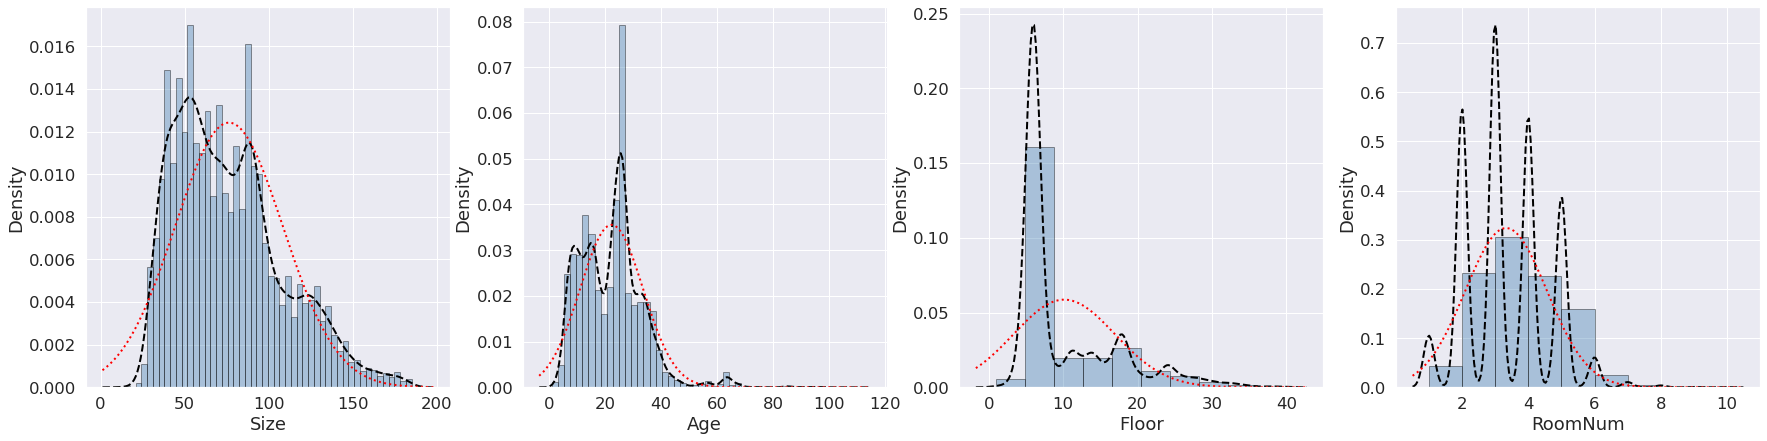

In [21]:
# Fig 4. distribution histograms for independent variables.
sns.set(font_scale = 1.5)
f4, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(30, 7))
# size
sns.distplot(a=df.Size, fit=stats.norm, norm_hist=True, ax=ax1, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# year
sns.distplot(a=df.Age, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# floor
sns.distplot(a=df.Floor, bins=10, fit=stats.norm, norm_hist=True, ax=ax3, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# room
sns.distplot(a=df.RoomNum, bins=9, fit=stats.norm, norm_hist=True, ax=ax4, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})

plt.savefig('./figs/fig6.jpg')
plt.show()

### Log Transformation for Linear Relationship
The distribution of Size, Age and Floor is positively skewed, and we need to perform log transformation for them.

In [22]:
#perform log transformation for Size, Age and Floor.
df['Size_0'],lambda_=stats.boxcox(df.Size)
df['Age_0'],lambda_=stats.boxcox(df.Age)
df['Floor_0'],lambda_=stats.boxcox(df.Floor)

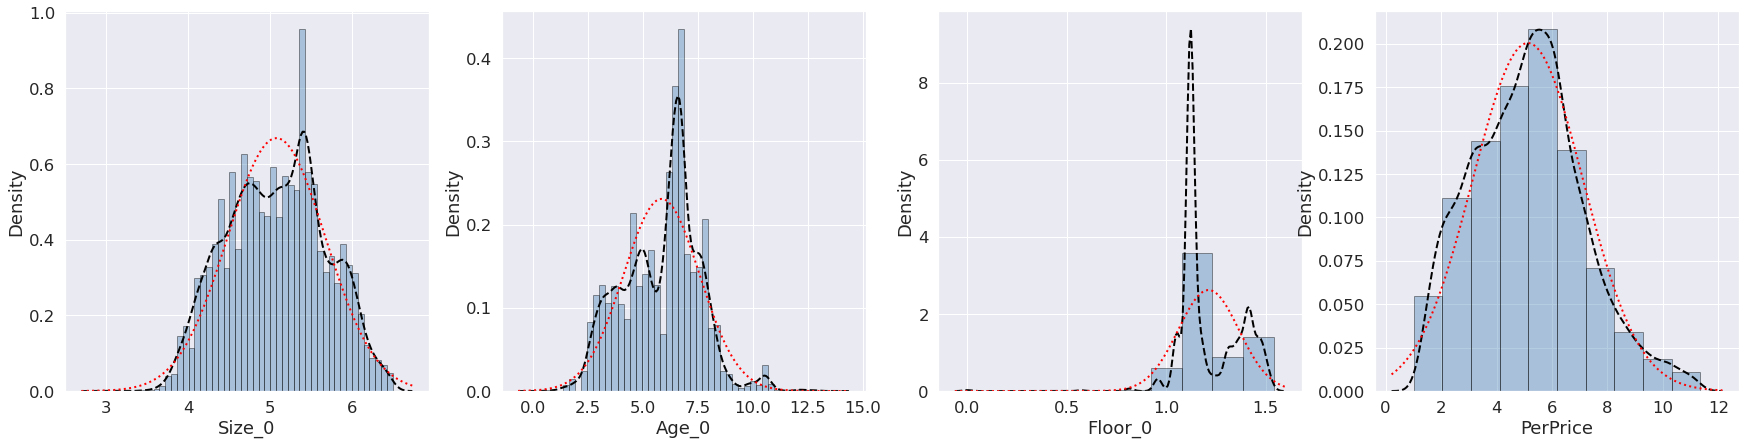

In [23]:
# Fig 5. distribution histograms for  Size, Age and Floor after log transformation and the dependent variable Unit price.
f4, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize=(30, 7))
# size
sns.distplot(a=df.Size_0, fit=stats.norm, norm_hist=True, ax=ax1, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# year
sns.distplot(a=df.Age_0, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# floor
sns.distplot(a=df.Floor_0, bins=10, fit=stats.norm, norm_hist=True, ax=ax3, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})
# perprice
sns.distplot(a=df.PerPrice, bins=10, fit=stats.norm, norm_hist=True, ax=ax4, 
             hist_kws={'color':'steelblue', 'edgecolor':'black'},
             kde_kws={'color':'black', 'linestyle':'--', 'linewidth':2},
             fit_kws={'color':'red', 'linestyle':':', 'linewidth':2})

plt.savefig('./figs/fig7.jpg')
plt.show()

sns.set(font_scale = 1)

### VIFs and Corelation Matrix for Identifying Multicollinearity 
Multicollinearity refers to the existence of high linear correlation between independent variables in the model, which brings serious consequences to the model.Variance inflation factor VIF can be used for identification. If VIF is greater than 5, it indicates that there is multicollinearity among variables.

In [24]:
# split train set and test set at the ratio of 8 to 2.
train,test,=train_test_split(df, test_size=0.2, random_state=0)

# select features for learning and prices for predicting.
y_test = test['Price']
x_test = test.drop(['Price','PerPrice','Price','Age','Floor'],axis=1)

model_2 = sm.formula.ols(formula='Price ~ Size_0 + Age_0+Decoration+RoomNum+Floor_0', data=train).fit() 
pred=model_2.predict(x_test)
print("the difference between actual and predicted values：\n",pd.DataFrame({'Prediction':pred,'Real':y_test}))
print("The partial regression coefficient of the model is：\n",model_2.params)

the difference between actual and predicted values：
        Prediction   Real
18277  439.549393  420.0
449    348.391394   75.0
7394   411.405652  200.0
11506  168.625531  263.0
23572  565.388927  758.0
...           ...    ...
4573   214.417939  230.0
17313  439.222446  410.0
8998   286.698912  305.0
23410  633.532639  668.0
5244   645.876968  910.0

[4746 rows x 2 columns]
The partial regression coefficient of the model is：
 Intercept    -1538.395627
Size_0         240.305335
Age_0           39.782869
Decoration      25.814986
RoomNum          3.336190
Floor_0        306.028278
dtype: float64


Calculate the VIFs for independent variables.

In [25]:
#calculate the VIFs for independent variables.
X=sm.add_constant(df.loc[:,['Floor_0', 'RoomNum', 'Size_0', 'Age_0', 'Decoration',]])
vif = pd.DataFrame()
vif["feature"]=X.columns
vif["VIF Factor"]=[variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
vif

,feature,VIF Factor
0,const,319.851792
1,Floor_0,1.333695
2,RoomNum,4.392584
3,Size_0,4.690853
4,Age_0,1.549159
5,Decoration,1.014655


The VIFs for all the independent variables are under 5, indicating a low multicollinearity in the model.
As the multiple linear regression is sensitive to outliesrs, we need to deal with the outliers.

In [26]:
outliers = model_1.get_influence()
leverage = outliers.hat_matrix_diag
dffits = outliers.dffits[0]
resid_stu = outliers.resid_studentized_external
cook = outliers.cooks_distance[0]
contat1 = pd.concat([pd.Series(leverage,name='leverage'),pd.Series(dffits,name='dffits'),
                              pd.Series(resid_stu,name='resid_stu'),pd.Series(cook,name='cook')],axis = 1)
train.index = range(train.shape[0])
df_outliers = pd.concat([train,contat1],axis=1)
df_outliers.head()

,Region,Floor,Year,Subway,Taxfree,RoomNum,Size,PerPrice,Price,Age,Decoration,Size_0,Age_0,Floor_0,leverage,dffits,resid_stu,cook
0,Pudong,6,1985,1,0,2,37.0,5.945946,220.0,36,2,4.191195,7.895567,1.122046,0.000265,0.001454,0.089274,3.524038e-07
1,Fengxian,6,1997,1,0,3,71.0,2.366197,168.0,24,3,5.086400,6.352334,1.122046,0.000082,-0.010020,-1.104808,1.673429e-05
2,Jingan,5,1976,1,0,2,36.0,5.694444,205.0,45,3,4.154582,8.856430,1.052930,0.000284,-0.007222,-0.428763,8.692909e-06
3,Changning,17,2001,1,1,5,114.0,8.201754,935.0,20,4,5.766917,5.734994,1.404477,0.000245,0.035759,2.282689,2.130646e-04
4,Pudong,6,2006,0,1,3,92.0,2.065217,190.0,15,4,5.455559,4.846975,1.122046,0.000313,-0.026179,-1.479249,1.142174e-04


In [27]:
#calculate the ratio of outliers to total listings.
outliers_ratio = sum(np.where((np.abs(df_outliers.resid_stu)>2),1,0))/df_outliers.shape[0]
outliers_ratio

0.057692307692307696

As the ration of outliers to the whole dataset is only 5.77%, not very high, we delete the outliers.

Normalization of features: 'Price','Size','Age'.

In [28]:
# Normalization of features: 'Price','Size','Age'
df_outliers = data_Znorm(df_outliers,'Size_0','Age_0','Decoration','RoomNum','Floor_0')

Return the results of the second model.

In [29]:
none_outliers = df_outliers.loc[np.abs(df_outliers.resid_stu)<=2]

# split train set and test set
train,test,=train_test_split(none_outliers, test_size=0.2, random_state=4)

# select features for learning and prices for predicting
y_test = test['Price']
x_test = test.drop(['Price','PerPrice','Size_0','Age_0'],axis=1)

model_3 = sm.formula.ols(formula='Price ~ Size_0_n + Age_0_n+Decoration_n+RoomNum_n+Floor_0', data=train).fit() 
pred=model_3.predict(x_test)
print("Difference between prediction and real value：\n",pd.DataFrame({'Prediction':pred,'Real':y_test}))
print("Coefficients：\n",model_3.params)

Difference between prediction and real value：
        Prediction   Real
18167  281.378887  234.0
4725   333.033808  320.0
1890   458.840293  370.0
12225  541.721167  505.0
13591  241.487362  235.0
...           ...    ...
16607  215.684455  206.0
4622   320.225385  358.0
8064   383.901696  512.0
3819   403.852986  265.0
1218   326.125720  335.0

[3577 rows x 2 columns]
Coefficients：
 Intercept      -801.976385
Size_0_n        823.093776
Age_0_n         561.668272
Decoration_n     73.428526
RoomNum_n        17.885746
Floor_0         310.826806
dtype: float64


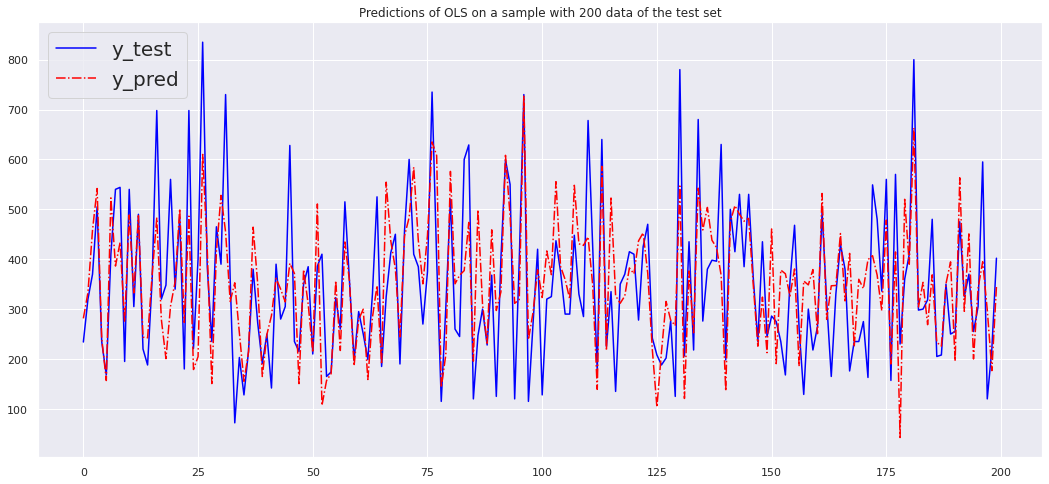

In [30]:
fig = plt.figure(figsize=(18,8))
plt.plot(range(200),y_test[0:200],color='blue',linewidth=1.5,linestyle='-',label='y_test')
plt.plot(range(200),pred[0:200],color='red',linewidth=1.5,linestyle='-.',label='y_pred')
plt.legend(fontsize=20)
plt.title('Predictions of OLS on a sample with 200 data of the test set')
plt.savefig('./figs/fig8.jpg')
plt.show()

### Draw the distribution of the residuals and the Residual vs Fitted plot.

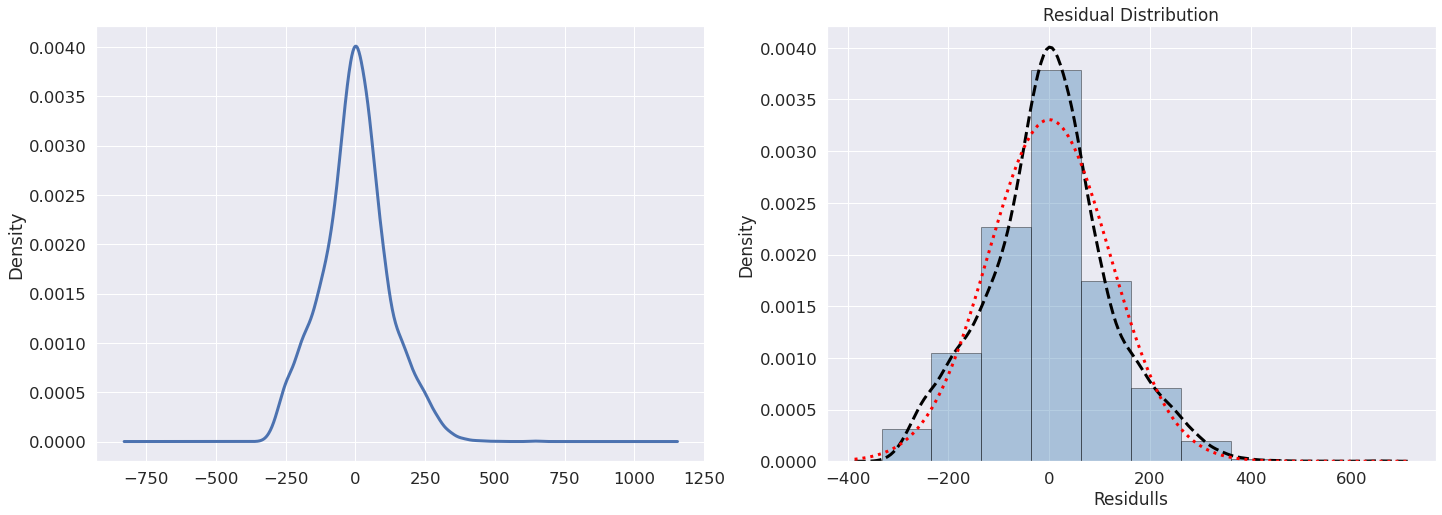

Residual mean: 3.328812266991903e-11


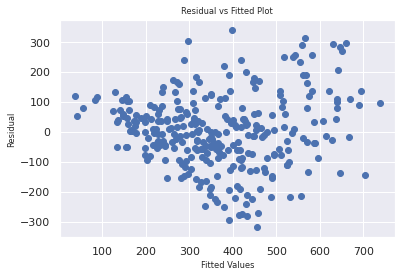

In [31]:
# draw the distribution of the residuals.
sns.set(font_scale = 1.5)
f5, [ax1, ax2] = plt.subplots(1,2, figsize=(24, 8))
model_3.resid.plot.density(linewidth=3, ax=ax1)
ax1.set_ylabel('Density')
sns.distplot(a=model_3.resid, bins=10, fit=stats.norm, norm_hist=True, ax=ax2, 
             hist_kws={'color': 'steelblue', 'edgecolor': 'black'},
             kde_kws={'color': 'black', 'linestyle': '--', 'linewidth': 3},
             fit_kws={'color': 'red', 'linestyle': ':', 'linewidth': 3})
ax2.set_ylabel('Density', fontsize=17)
ax2.set_xlabel('Residulls', fontsize=17)
plt.title('Residual Distribution', fontsize=17)
plt.savefig('./figs/fig9.jpg')
plt.show()
sns.set(font_scale = 1)
print("Residual mean:", np.mean(model_3.resid))

#draw the Residual vs Fitted plot.
plt.scatter(model_3.fittedvalues[300:600],model_3.resid[300:600])
plt.xlabel('Fitted Values', fontsize=8.3)
plt.ylabel('Residual', fontsize=8.3)
plt.title('Residual vs Fitted Plot', fontsize=8.3)
plt.savefig('./figs/fig10.jpg')
plt.show()

### return the results of the second regression model, which showed a huge improvement from the first one.

In [32]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     3580.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:04:16   Log-Likelihood:                -88886.
No. Observations:               14308   AIC:                         1.778e+05
Df Residuals:                   14302   BIC:                         1.778e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -801.9764     12.909    -62.125      0.000    -827.280    -776.673
Size_0_n       823.0938     13.009     63.269      0.000     797.594     848.594
Age_0_n        561.6683      9.886     56.812      0.000     542.289     581.047
Decoration_n    73.4285      3.499     20.986      0.000      66.570      80.287
RoomNum_n       17.8857     15.447      1.158      0.247     -12.392      48.163
Floor_0        310.8268      7.736     40.179      0.000     295.663     325.990
==============================================================================
Omnibus:                      106.643   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.025
Skew:                           0.161   Prob(JB):                     3.18e-27
Kurtosis:                       3.318   Cond. No.                         37.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### check drops in adjusted R2 for each variables to evaluate their influence(based on the second regression)

In [33]:
#  check the drop in adjusted R2 for Size. 
model_noSize = sm.formula.ols(formula='Price ~  Age_0_n+Decoration_n+RoomNum_n+Floor_0', data=train).fit() 
print("Coefficient：\n",model_noSize.params)
model_noSize.summary()

Coefficient：
 Intercept      -581.676574
Age_0_n         458.460230
Decoration_n     74.887746
RoomNum_n       844.897083
Floor_0         394.752047
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     2715.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:04:16   Log-Likelihood:                -90651.
No. Observations:               14308   AIC:                         1.813e+05
Df Residuals:                   14303   BIC:                         1.814e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -581.6766     14.063    -41.364      0.000    -609.241    -554.112
Age_0_n        458.4602     11.031     41.561      0.000     436.838     480.083
Decoration_n    74.8877      3.958     18.919      0.000      67.129      82.646
RoomNum_n      844.8971      9.311     90.741      0.000     826.646     863.148
Floor_0        394.7520      8.622     45.784      0.000     377.852     411.652
==============================================================================
Omnibus:                      674.395   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              935.557
Skew:                           0.454   Prob(JB):                    7.02e-204
Kurtosis:                       3.862   Cond. No.                         29.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
#  check the drop in adjusted R2 for Decoration.
model_noDecoration = sm.formula.ols(formula='Price ~ Size_0_n +Age_0_n+RoomNum_n+Floor_0', data=train).fit() 
print("Coefficient：\n",model_noDecoration.params)
model_noDecoration.summary()

Coefficient：
 Intercept   -768.725155
Size_0_n     824.893349
Age_0_n      580.981971
RoomNum_n     32.846580
Floor_0      317.445621
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     4235.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:04:16   Log-Likelihood:                -89103.
No. Observations:               14308   AIC:                         1.782e+05
Df Residuals:                   14303   BIC:                         1.783e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -768.7252     13.007    -59.102      0.000    -794.220    -743.230
Size_0_n     824.8933     13.207     62.457      0.000     799.005     850.782
Age_0_n      580.9820      9.994     58.135      0.000     561.393     600.571
RoomNum_n     32.8466     15.665      2.097      0.036       2.140      63.553
Floor_0      317.4456      7.847     40.452      0.000     302.064     332.828
==============================================================================
Omnibus:                      116.699   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.164
Skew:                           0.164   Prob(JB):                     2.71e-30
Kurtosis:                       3.347   Cond. No.                         34.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
#  check the drop in adjusted R2 for Age.
model_noAge = sm.formula.ols(formula='Price ~ Size_0_n +Decoration_n+RoomNum_n+Floor_0', data=train).fit() 
print("Coefficient：\n",model_noAge.params)
model_noAge.summary()

Coefficient：
 Intercept      -263.003770
Size_0_n        701.146124
Decoration_n     91.932998
RoomNum_n       -36.043873
Floor_0         123.951955
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     2993.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:04:16   Log-Likelihood:                -90341.
No. Observations:               14308   AIC:                         1.807e+05
Df Residuals:                   14303   BIC:                         1.807e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -263.0038      9.692    -27.137      0.000    -282.001    -244.007
Size_0_n       701.1461     14.205     49.360      0.000     673.303     728.989
Decoration_n    91.9330      3.857     23.837      0.000      84.373      99.493
RoomNum_n      -36.0439     17.068     -2.112      0.035     -69.500      -2.588
Floor_0        123.9520      7.751     15.991      0.000     108.758     139.146
==============================================================================
Omnibus:                      127.051   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.315
Skew:                           0.234   Prob(JB):                     5.04e-29
Kurtosis:                       3.006   Cond. No.                         36.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
#  check the drop in adjusted R2 for Room Number.
model_noRoomNum = sm.formula.ols(formula='Price ~ Size_0_n +Decoration_n+Age_0_n+Floor_0', data=train).fit() 
print("Coefficient：\n",model_noRoomNum.params)
model_noRoomNum.summary()

Coefficient：
 Intercept      -802.927542
Size_0_n        835.840831
Decoration_n     73.615510
Age_0_n         560.964769
Floor_0         309.233565
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4475.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:04:16   Log-Likelihood:                -88886.
No. Observations:               14308   AIC:                         1.778e+05
Df Residuals:                   14303   BIC:                         1.778e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -802.9275     12.883    -62.324      0.000    -828.180    -777.675
Size_0_n       835.8408      6.932    120.578      0.000     822.253     849.428
Decoration_n    73.6155      3.495     21.061      0.000      66.764      80.467
Age_0_n        560.9648      9.868     56.847      0.000     541.622     580.307
Floor_0        309.2336      7.613     40.620      0.000     294.312     324.156
==============================================================================
Omnibus:                      105.839   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.663
Skew:                           0.161   Prob(JB):                     6.29e-27
Kurtosis:                       3.314   Cond. No.                         31.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
#  check the drop in adjusted R2 for Floor.
model_noFloor = sm.formula.ols(formula='Price ~ Size_0_n +Decoration_n+Age_0_n+RoomNum_n', data=train).fit() 
print("Coefficient：\n",model_noFloor.params)
model_noFloor.summary()

Coefficient：
 Intercept      -382.728266
Size_0_n        912.721167
Decoration_n     79.160177
Age_0_n         392.764594
RoomNum_n       -92.504586
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     3659.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:04:16   Log-Likelihood:                -89651.
No. Observations:               14308   AIC:                         1.793e+05
Df Residuals:                   14303   BIC:                         1.793e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -382.7283      8.018    -47.736      0.000    -398.444    -367.013
Size_0_n       912.7212     13.520     67.508      0.000     886.220     939.223
Decoration_n    79.1602      3.688     21.464      0.000      71.931      86.389
Age_0_n        392.7646      9.439     41.609      0.000     374.262     411.267
RoomNum_n      -92.5046     16.035     -5.769      0.000    -123.935     -61.074
==============================================================================
Omnibus:                      112.247   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.467
Skew:                           0.145   Prob(JB):                     1.41e-30
Kurtosis:                       3.383   Cond. No.                         28.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## PART4: RANDOM FOREST MODEL
### As the R2 value in first and second models are not vary satisfying, we applied the random forest model, in the hope that it would return a higher R2.

In [38]:
df.columns

# Normalization of features: 'Price','Size','Age'.
df = data_Znorm(df,'Price','Size','Age')

# select features for learning and prices for predicting.
prices = df['Price']
feature = df.drop(['Price','Price_n','PerPrice','Size','Age','Size_0', 'Age_0', 'Floor_0','Subway', 'Taxfree','Region'],axis=1)

# transform dataframes to numpy arrays.
features = np.array(feature)
prices = np.array(prices)

# split train set and test set according to the ratio of 8:2.
x_train, x_test, y_train, y_test=train_test_split(features,prices, test_size=0.2, random_state=0)

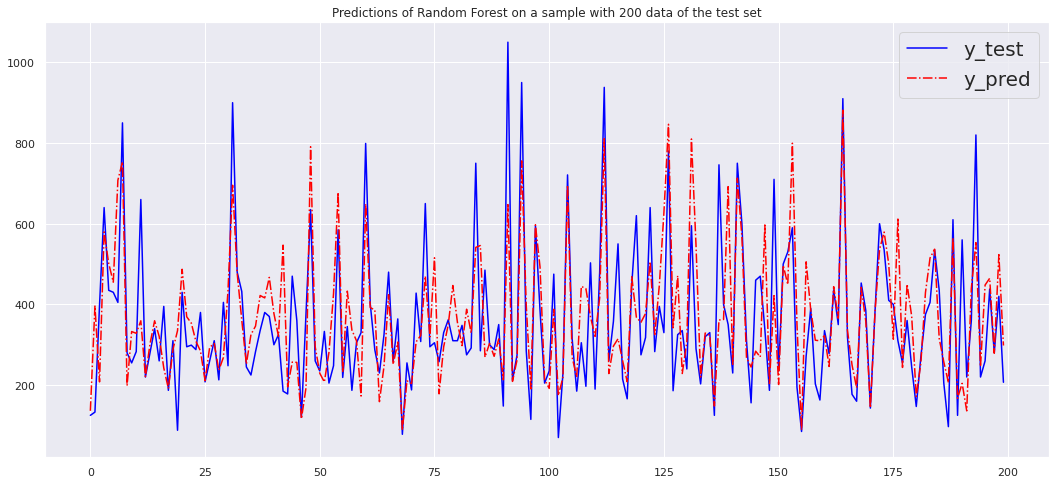

In [39]:
# Random Forest regressor model.
rf= RandomForestRegressor().fit(x_train,y_train)
y_pred = rf.predict(x_test)
fig = plt.figure(figsize=(18,8))
plt.plot(range(200),y_test[100:300],color='blue',linewidth=1.5,linestyle='-',label='y_test')
plt.plot(range(200),y_pred[100:300],color='red',linewidth=1.5,linestyle='-.',label='y_pred')
plt.legend(fontsize=20)
plt.title('Predictions of Random Forest on a sample with 200 data of the test set')
plt.savefig('./figs/fig11.jpg')
plt.show()

Return statistics from the model, and print the importances of different variables.

In [40]:
print('mean_absolute_error：', mean_absolute_error(y_test, y_pred))
print('mean_squared_error：', mean_squared_error(y_test, y_pred))
print('median_absolute_error：', median_absolute_error(y_test, y_pred))
print('explained_variance_score：', explained_variance_score(y_test, y_pred))
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), feature.columns), reverse=True))

mean_absolute_error： 87.01218978491524
mean_squared_error： 15818.929985013105
median_absolute_error： 56.901249999999976
explained_variance_score： 0.6216720834202877
[(0.5921, 'Size_n'), (0.1414, 'Floor'), (0.0949, 'Age_n'), (0.0938, 'Year'), (0.0415, 'RoomNum'), (0.0361, 'Decoration')]


The result from the random forrest model is a huge improvement.

## PART 5: K-MEANS CLUSTERING
I implemented all the k-means clusterings for Unit Price and every combination of 2 structural characteristics, and find clustering pattern with 5 clusters using Size and Age is most obvious among all combinations

In [41]:
#change region into dummy variables for Region，one_hot encoding。
region=df.Region
dummis = pd.get_dummies(df.Region)
df = pd.concat([df,dummis],axis=1)
df = df.drop('Region',axis=1)

Final K-Means clustering on features: size, price, Age of second-hand houses.

In [42]:
# final K-Means clustering on features: size, price, Age of second-hand houses.
df_cluster = df[['Size_n', 'Price_n','Age_n']]
km = KMeans(n_clusters=5, n_init=10)
y_pred = km.fit_predict(df_cluster)

df['clusters'] = km.labels_.tolist()
df['clusters']=df['clusters'].map(lambda x : x+1)

In [43]:
df_cluster['clusters']=df['clusters']

df_cluster.loc[df_cluster.clusters==1]['Price_n']

54       0.396040
58       0.326733
59       0.326733
71       0.351485
72       0.512871
           ...   
24448    0.361386
24449    0.331683
24456    0.396040
24466    0.480198
24479    0.277228
Name: Price_n, Length: 2605, dtype: float64

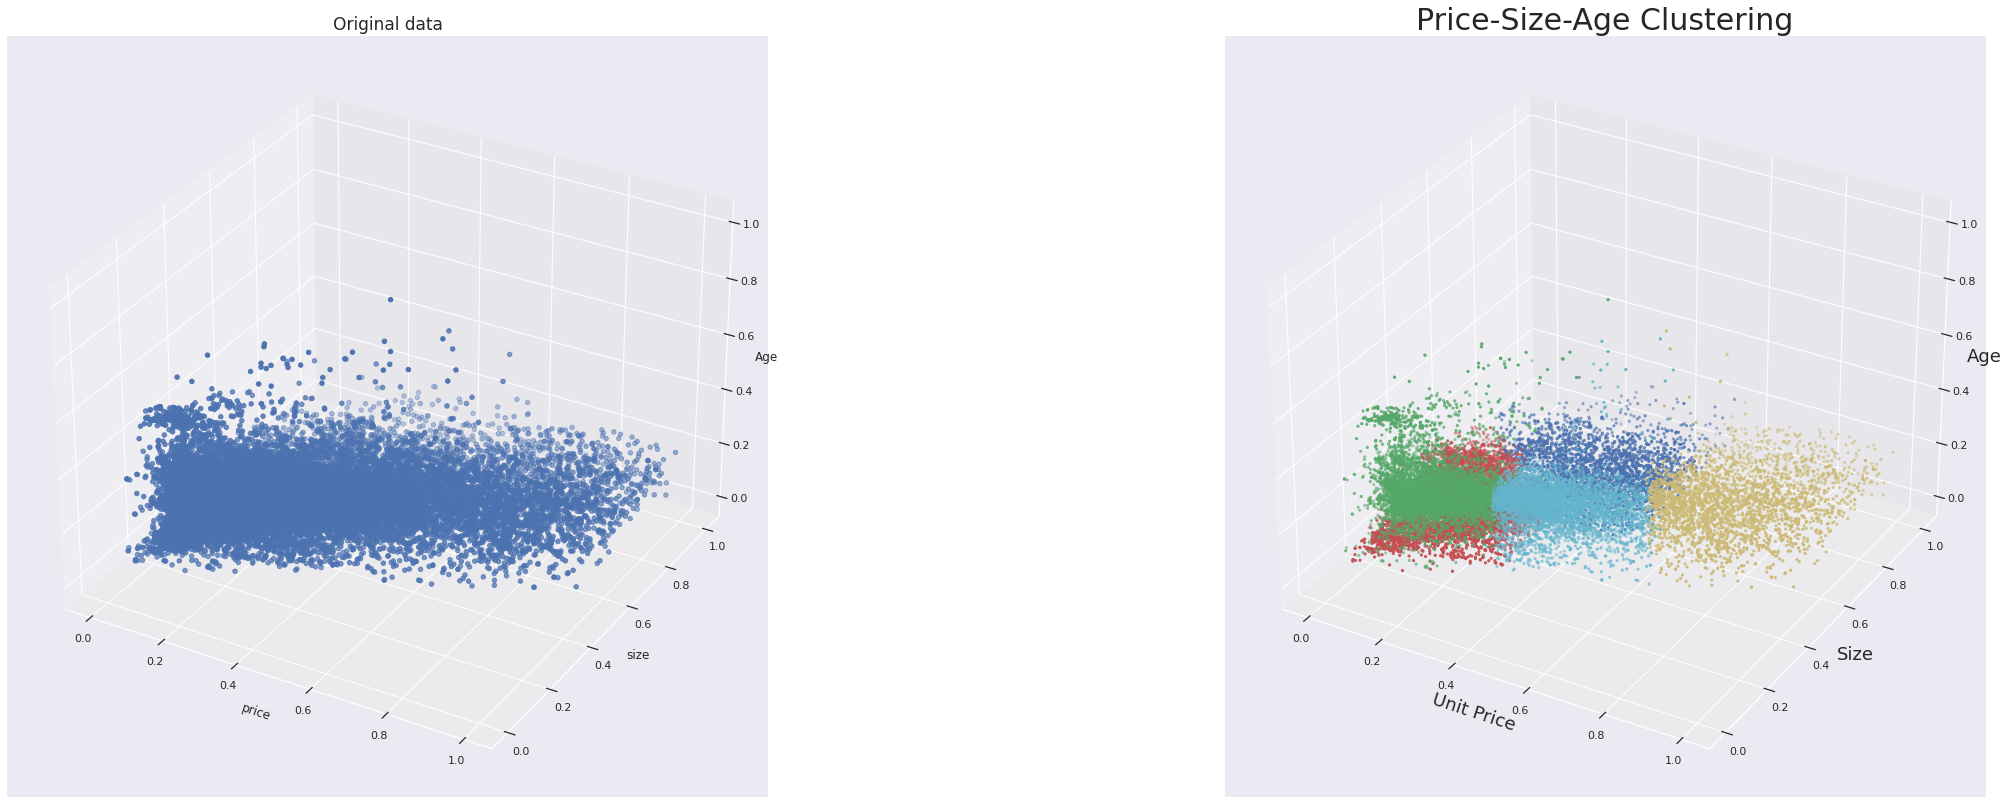

In [44]:
fig = plt.figure(figsize = (40,14))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(df_cluster['Price_n'], df_cluster['Size_n'],df_cluster['Age_n'],marker='o')
ax1.set_xlabel('price', fontsize=12)
ax1.set_ylabel('size', fontsize=12)
ax1.set_zlabel('Age', fontsize=12)
ax1.set_title('Original data', fontsize=17)

ax2 = fig.add_subplot(122,projection='3d')
ax2.scatter(df_cluster.loc[df_cluster.clusters==1]['Price_n'], df_cluster.loc[df_cluster.clusters==1]['Size_n'],
            df_cluster.loc[df_cluster.clusters==1]['Age_n'],label='1',marker='o',color='b',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==2]['Price_n'], df_cluster.loc[df_cluster.clusters==2]['Size_n'],
            df_cluster.loc[df_cluster.clusters==2]['Age_n'],label='2',marker='o',color='r',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==3]['Price_n'], df_cluster.loc[df_cluster.clusters==3]['Size_n'],
            df_cluster.loc[df_cluster.clusters==3]['Age_n'],label='3',marker='o',color='y',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==4]['Price_n'], df_cluster.loc[df_cluster.clusters==4]['Size_n'],
            df_cluster.loc[df_cluster.clusters==4]['Age_n'],label='4',marker='o',color='g',s=5)
ax2.scatter(df_cluster.loc[df_cluster.clusters==5]['Price_n'], df_cluster.loc[df_cluster.clusters==5]['Size_n'],
            df_cluster.loc[df_cluster.clusters==5]['Age_n'],label='5',marker='o',color='c',s=5)
#ax2.legend()
ax2.set_xlabel('Unit Price', fontsize=18)
ax2.set_ylabel('Size', fontsize=18)
ax2.set_zlabel('Age', fontsize=18)
ax2.set_title('Price-Size-Age Clustering', fontsize=30)

plt.savefig('./figs/fig12.jpg')
plt.show()

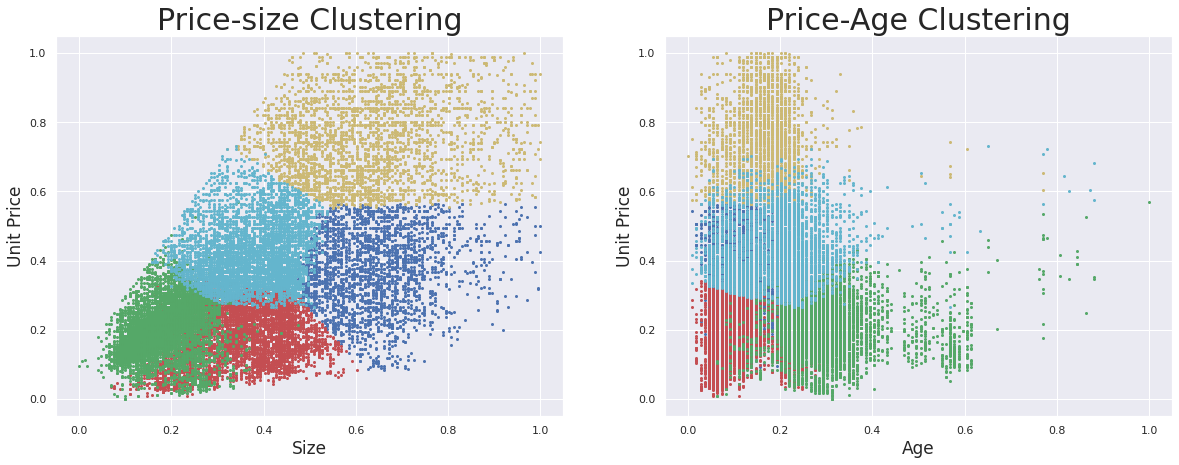

In [45]:
fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(121)
ax1.scatter(df_cluster.loc[df_cluster.clusters==1]['Size_n'],df_cluster.loc[df_cluster.clusters==1]['Price_n'],s=4,
            label='1',marker='o',color='b')
ax1.scatter(df_cluster.loc[df_cluster.clusters==2]['Size_n'],df_cluster.loc[df_cluster.clusters==2]['Price_n'],s=4,
            label='2',marker='o',color='r')
ax1.scatter(df_cluster.loc[df_cluster.clusters==3]['Size_n'],df_cluster.loc[df_cluster.clusters==3]['Price_n'],s=4,
            label='3',marker='o',color='y')
ax1.scatter(df_cluster.loc[df_cluster.clusters==4]['Size_n'],df_cluster.loc[df_cluster.clusters==4]['Price_n'],s=4,
            label='4',marker='o',color='g')
ax1.scatter(df_cluster.loc[df_cluster.clusters==5]['Size_n'],df_cluster.loc[df_cluster.clusters==5]['Price_n'],s=4,
            label='5',marker='o',color='c')
#ax1.legend()
ax1.set_ylabel('Unit Price', fontsize=17)
ax1.set_xlabel('Size', fontsize=17)
ax1.set_title('Price-size Clustering', fontsize=30)

ax2 = fig.add_subplot(122)

ax2.scatter(df_cluster.loc[df_cluster.clusters==1]['Age_n'],df_cluster.loc[df_cluster.clusters==1]['Price_n'],s=4,
            label='1',marker='o',color='b')
ax2.scatter(df_cluster.loc[df_cluster.clusters==2]['Age_n'],df_cluster.loc[df_cluster.clusters==2]['Price_n'],s=4,
            label='2',marker='o',color='r')
ax2.scatter(df_cluster.loc[df_cluster.clusters==3]['Age_n'],df_cluster.loc[df_cluster.clusters==3]['Price_n'],s=4,
            label='3',marker='o',color='y')
ax2.scatter(df_cluster.loc[df_cluster.clusters==4]['Age_n'],df_cluster.loc[df_cluster.clusters==4]['Price_n'],s=4,
            label='4',marker='o',color='g')
ax2.scatter(df_cluster.loc[df_cluster.clusters==5]['Age_n'],df_cluster.loc[df_cluster.clusters==5]['Price_n'],s=4,
            label='5',marker='o',color='c')
#ax2.legend()
ax2.set_ylabel('Unit Price', fontsize=17)
ax2.set_xlabel('Age', fontsize=17)
ax2.set_title('Price-Age Clustering', fontsize=30)

plt.savefig('./figs/fig13.jpg', fontsize=17)
plt.show()

In [46]:
#show the number of houses in every cluster.
df['clusters'].value_counts()
#show the mean values of price, size, age, room number, unit price and decoration for every cluster.
df.groupby(df['clusters'])['Price','Size','Age','RoomNum','PerPrice','Decoration'].mean()

,Price,Size,Age,RoomNum,PerPrice,Decoration
clusters,,,,,,
1,424.460345,123.322073,14.942418,4.872553,3.490856,3.290595
2,229.528672,72.606905,13.769541,3.283035,3.245431,3.034350
3,807.307530,122.124911,18.899714,4.725553,6.848879,3.467166
4,252.361181,45.251662,32.817735,2.232119,5.730655,3.205663
5,470.525339,77.303477,22.084266,3.450992,6.246935,3.358476


In [47]:
 # show the top 3 districts with most listed houses. 
df['Region'] = region
for i in df['clusters'].unique():
    print(df[df['clusters']==i].Region.value_counts().head(3))

Minhang    869
Baoshan    705
Pudong     650
Name: Region, dtype: int64
Jiading      1114
Fengxian      774
Songjiang     750
Name: Region, dtype: int64
Yangpu       1466
Putuo        1104
Changning     796
Name: Region, dtype: int64
Minhang    426
Putuo      325
Jingan     275
Name: Region, dtype: int64
Songjiang    591
Baoshan      408
Fengxian     319
Name: Region, dtype: int64
